In [25]:
import cv2
import math
import numpy as np
from PIL import Image, ImageDraw, ImageFilter, ImageOps
import time
from glob import glob

class Make_mask():
    def __init__(self,frame):
        self.all_mask_dict = {}
        self.frame = frame
        self.gray = cv2.cvtColor(self.frame, cv2.COLOR_RGB2GRAY)
        self.gray = cv2.GaussianBlur(self.gray, (33,33), 1)
        #白黒に二値化したときに，thresholdより白い部分の色を取得しない
        self.threshold = 150

        #円検出用パラメータ
        # self.min_radius = 30
        self.min_radius = 20
        self.max_radius = 200
        self.radius_num = 2

        #矩形検出用パラメータ
        self.cond_area = 1000

    ###矩形検知用###
    def angle(self, pt1, pt2, pt0) -> float:
        dx1 = float(pt1[0,0] - pt0[0,0])
        dy1 = float(pt1[0,1] - pt0[0,1])
        dx2 = float(pt2[0,0] - pt0[0,0])
        dy2 = float(pt2[0,1] - pt0[0,1])
        v = math.sqrt((dx1*dx1 + dy1*dy1)*(dx2*dx2 + dy2*dy2) )
        return (dx1*dx2 + dy1*dy2)/ v

    def findSquares(self, bin_image, image):
        # 輪郭取得
        contours,hierarchy = cv2.findContours(bin_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        for i, cnt in enumerate(contours):
            # 輪郭の周囲に比例する精度で輪郭を近似する
            arclen = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, arclen*0.02, True)

            #四角形の輪郭は、近似後に4つの頂点があります。
            #比較的広い領域が凸状になります。

            # 凸性の確認 
            area = abs(cv2.contourArea(approx))
            if approx.shape[0] == 4 and area > self.cond_area and cv2.isContourConvex(approx) :
                maxCosine = 0

                for j in range(2, 5):
                    # 辺間の角度の最大コサインを算出
                    cosine = abs(self.angle(approx[j%4], approx[j-2], approx[j-1]))
                    maxCosine = max(maxCosine, cosine)

                # すべての角度の余弦定理が小さい場合
                #（すべての角度は約90度です）次に、quandrangeを書き込みます
                # 結果のシーケンスへの頂点
                if maxCosine < 0.3 :
                    # 四角判定!!
                    rcnt = approx.reshape(-1,2)
                    new_img = np.zeros(image.shape,dtype=np.uint8)
                    cv2.fillPoly(new_img, [rcnt],(255,255,255), lineType=cv2.LINE_8, shift=0)
                    new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
            
                    return new_img
    ################

    #frameから円検出を行い，マスク作成
    def detection_circle(self):
        mask_list = []
        circles = cv2.HoughCircles(self.gray, cv2.HOUGH_GRADIENT, 1, 60, param1=10, param2=85, minRadius=self.min_radius, maxRadius=self.max_radius)
        if str(circles) != "None":
            circles = np.uint16(np.around(circles))
            for e,i in enumerate(circles[0,:]):

                mask = np.zeros((self.frame.shape[0],self.frame.shape[1]),dtype=np.uint8)
                cv2.circle(mask,(i[0],i[1]),0,(255,255,255),i[2]*2-20)
                mask_list.append(mask)

                if e+1==self.radius_num:
                    break

        return mask_list

    #frameから矩形検出を行い，マスク作成
    def detection_rect(self):
        mask_list = []
        _, bw = cv2.threshold(self.gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        mask = self.findSquares(bw, self.frame)
        if mask != None:
            mask_list.append(mask)
        return mask_list

    #マスクから皿領域内の料理部分だけの三値画像と二値画像を作成する
    def make_santi_and_niti(self,mask):
        #マスクと同じサイズの白画像にmaskをマスクにし，
        #フレームを貼り付ける
        white = np.ones((mask.shape[0],mask.shape[1],3),dtype=np.uint8)*255
        white_pil = Image.fromarray(white)
        frame_pil = Image.fromarray(frame)
        mask_pil = Image.fromarray(mask)
        white_pil.paste(frame_pil,(0,0),mask=mask_pil)

        #平均色取得
        crop_gray = cv2.cvtColor(np.array(white_pil), cv2.COLOR_RGB2GRAY)
        rr,cc = np.where(crop_gray<=self.threshold)
        average_color = self.calc_average_color(white=white,rr=rr,cc=cc)

        #三値用マスク作成(料理部分だけ白，それ以外は黒の画像)
        santi_mask = np.zeros((mask.shape[0],mask.shape[1]),dtype=np.uint8)
        santi_mask[rr,cc] = 255

        #三値作成(皿マスクをRGBに変換し，料理部分のみframeから貼り付ける)
        santi_pil = Image.fromarray(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))
        santi_pil.paste(frame_pil,(0,0),mask=Image.fromarray(santi_mask))
        santi_pil = Image.fromarray(cv2.cvtColor(np.array(santi_pil), cv2.COLOR_RGB2BGR))

        #二値作成（santiを2値化）
        niti = np.where(np.array(santi_pil.convert("L"))<255,0,255)
        niti_pil = Image.fromarray(niti.astype(np.uint8))

        return niti_pil, santi_pil, average_color

    def calc_average_color(self,white,rr,cc):
        #whiteをグレースケール化し，thresholdを基準に料理領域とそれ以外を2値化
        not_white = white[rr,cc]
        B_ave = np.mean(not_white[:,0])
        G_ave = np.mean(not_white[:,1])
        R_ave = np.mean(not_white[:,2])
        return np.array([R_ave,G_ave,B_ave])

    #all_mask_dictにマスクを追加する
    def make_all_dict(self):
        print("皿検出開始")
        mask_count = 0
        rect_mask_list = self.detection_rect()
        for mask in rect_mask_list:
            niti,santi,average_color = self.make_santi_and_niti(mask=mask)
            self.all_mask_dict[mask_count] = {}
            self.all_mask_dict[mask_count]["皿"] = Image.fromarray(mask)
            self.all_mask_dict[mask_count]["二値"] = niti
            self.all_mask_dict[mask_count]["三値"] = santi
            self.all_mask_dict[mask_count]["平均色"] = average_color
            mask_count+=1

        circle_mask_list = self.detection_circle()
        for mask in circle_mask_list:
            niti,santi,average_color = self.make_santi_and_niti(mask=mask)
            self.all_mask_dict[mask_count] = {}
            self.all_mask_dict[mask_count]["皿"] = Image.fromarray(mask)
            self.all_mask_dict[mask_count]["二値"] = niti
            self.all_mask_dict[mask_count]["三値"] = santi
            self.all_mask_dict[mask_count]["平均色"] = average_color
            mask_count+=1
        
        print("皿検出終了")
        return self.all_mask_dict

# make_mask = Make_mask(frame=None)

In [26]:
class Make_gif():
    def __init__(self):
        #最初にgifを読み込んでおく
        self.gif_dict = {}
        self.gif_files = glob("./gif2/*gif")
        self.fps = None
        for e,ALPHA_GIF_PATH in enumerate(self.gif_files):
            gif_image_list = []
            cap2 = cv2.VideoCapture(ALPHA_GIF_PATH) # gifファイルを読み込み
            self.fps = cap2.get(cv2.CAP_PROP_FPS)        # fps取得

            while True:
                ret, frame = cap2.read()
                if not ret:
                    break

                # BGRをRGBにする
                img_array = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # numpyのarrayからPillowのimage objectを作る
                img = Image.fromarray(img_array)     #gifフレーム
                gif_image_list.append(img)
            self.gif_dict[e] = gif_image_list
        print("gif読み込み完了")

    #平均色からgifを選択する関数
    def select_gif(self, R_ave, G_ave, B_ave):
        num = 0
        #青の閾値(パイナップル)
        if G_ave >= 150:
            num = 2
        # オレンジの閾値（サーモン）
        elif R_ave >= 180 and G_ave <= 110 and B_ave <= 110:
            num = 1
        #角煮
        elif R_ave <= 140 and G_ave <= 120 and B_ave <= 100:
            num = 0
        return num

    def make_gif_image(self,json_np):
        print("gif合成開始")
        im_list = [] # Pillowのimageリスト
        for num,dic in json_np.items():
            sara = dic["皿"]
            base = dic["三値"]
            mask = dic["二値"]
            R_ave,G_ave,B_ave = dic["平均色"]
            #平均色からgif選択
            gif_num = self.select_gif(R_ave=R_ave, G_ave=G_ave, B_ave=B_ave)             
            gif_image_list = self.gif_dict[gif_num]
            #gif合成
            if num==0:
                for img in gif_image_list:

                    img = img.resize(mask.size)
                    base_copy = base.copy()
                    base_copy.paste(img,(0,0),mask=mask)
                    new_image = np.array(base_copy, dtype=np.uint8)
                    im_list.append(new_image)      #合成画像をリスト追加
            else:
                for e,img in enumerate(gif_image_list):

                    img = img.resize(mask.size)           #マスク画像にリサイズ
                    base_copy = base.copy()
                    base_copy.paste(img,(0,0),mask=mask)

                    new_base = Image.fromarray(im_list[e])
                    new_base.paste(base_copy,(0,0),mask=sara)

                    new_image = np.array(new_base, dtype=np.uint8)

                    im_list[e] = new_image      #合成画像をリスト追加
        print("gif合成終了")

        return im_list,self.fps

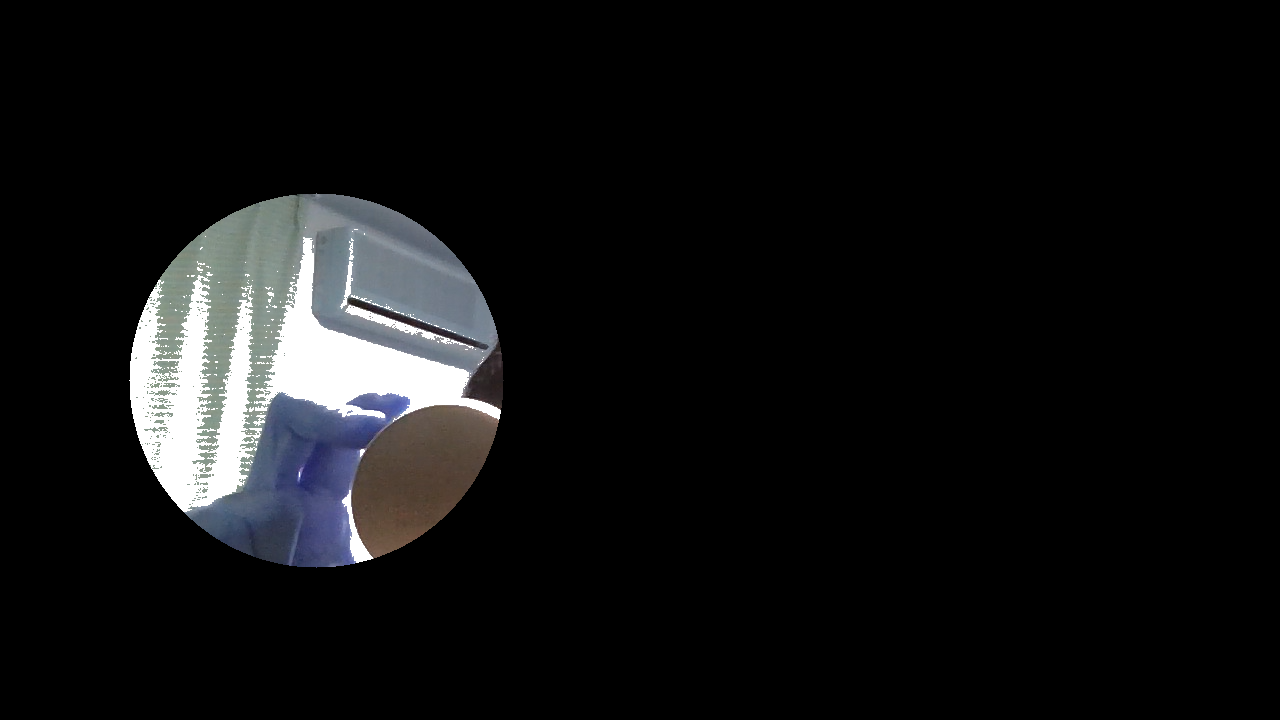

In [27]:
json_np_new[0]["三値"]

In [28]:
import tkinter as tk


#カメラ取得用
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc("M", "J", "P", "G"))
# cap.set(cv2.CAP_PROP_FPS, 60)           # カメラFPSを60FPSに設定
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920) # カメラ画像の横幅を1280に設定
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1200) # カメラ画像の縦幅を720に設定
print("カメラ取得")

#ウィンドウサイズ
root = tk.Tk()
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()


start_time = time.time()
elapsed_time_last = 0
elapsed_time_last_2 = 0
#gifを作成する時間の間隔
get_interval_gif = 20
#maskを作成する時間の間隔
get_interval_mask = 20

get_interval_beep = 16
num = 0


####
cv2.namedWindow('test', cv2.WINDOW_NORMAL)
cv2.setWindowProperty("test",cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_FULLSCREEN)
####

print("初期読み込み開始")
#最初
all_black = np.zeros((1200,1920),dtype=np.uint8)
#gif読み込み
make_gif = Make_gif()
while True:
    ret, frame = cap.read()
    cv2.imshow("camera",frame)
    make_mask = Make_mask(frame=frame)
    json_np_new = make_mask.make_all_dict()
    if json_np_new != 0:
        json_np = json_np_new
        im_list,fps = make_gif.make_gif_image(json_np=json_np)
        break

print("初期読み込み終了")

while True:

    ret, frame = cap.read()
    cv2.imshow("camera",frame)
    elapsed_time = int(time.time() - start_time)
    
    # if elapsed_time - elapsed_time_last_2 >= get_interval_beep:
    #     winsound.Beep(1000, 10)
    
    if elapsed_time - elapsed_time_last >= get_interval_gif:
        print("{} seconds passed".format(elapsed_time))
        cv2.destroyAllWindows()
        time.sleep(0.1)
        for i in range(50):
            ret, frame = cap.read()
            
        ###
        make_mask = Make_mask(frame=frame)
        json_np_new = make_mask.make_all_dict()
        if json_np_new != 0:
            json_np = json_np_new
            
        im_list,fps = make_gif.make_gif_image(json_np)
        #初期化
        num = 0
        elapsed_time_last = elapsed_time
        elapsed_time_last_2 = elapsed_time

    #初期化
    if num >= len(im_list):
        num = 0
    

    ###
    img = cv2.cvtColor(im_list[num], cv2.COLOR_RGB2BGR)
    # img = im_list[num]
    #####
    cv2.namedWindow('test', cv2.WINDOW_NORMAL)
    cv2.setWindowProperty("test",cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_FULLSCREEN)
    cv2.imshow("test",img)
    cv2.imwrite("imgs/{}giff.jpg".format(num),img)
    ###

    num+=1
    time.sleep(1/fps)

    #Qキーで終了
    key = cv2.waitKey(10)
    if key == ord("q"):
        break

cv2.destroyAllWindows()

    # time.sleep(1/fps)
    # print(1)

カメラ取得
初期読み込み開始
gif読み込み完了
皿検出開始
皿検出終了
gif合成開始
gif合成終了
初期読み込み終了
20 seconds passed
皿検出開始
皿検出終了
gif合成開始
gif合成終了
40 seconds passed
皿検出開始
皿検出終了
gif合成開始
gif合成終了
60 seconds passed
皿検出開始
皿検出終了
gif合成開始
gif合成終了
80 seconds passed
皿検出開始
皿検出終了
gif合成開始
gif合成終了
